1. From the Howell1 dataset, consider only the people younger than 13 years
old. Estimate the causal association between age and weight. Assume that
age influences weight through two paths. First, age influences height, and
height influences weight. Second, age directly influences weight through agerelated changes in muscle growth and body proportions.
Draw the DAG that represents these causal relationships. And then write
a generative simulation that takes age as an input and simulates height and
weight, obeying the relationships in the DAG.


In [1]:
import pandas as pd

howell_raw = pd.read_csv("week02/howell.csv", sep=";")

howell = howell_raw.query("age < 13")

howell

,height,weight,age,male
18,121.920,19.617854,12.0,1
19,105.410,13.947954,8.0,0
20,86.360,10.489315,6.5,0
24,109.220,15.989118,7.0,0
30,114.300,17.860185,11.0,1
...,...,...,...,...
531,87.630,10.659412,6.0,0
535,114.935,17.519991,7.0,1
536,67.945,7.229122,1.0,0
538,76.835,8.022908,1.0,1


In [52]:
import numpy as np
import pymc3 as pm
import arviz as az
from quap import quap

y = howell["weight"].values
x = howell["age"].values

# Normal with unknown mean and log-variance, with uniform priors 
with pm.Model() as linear_model: 
  intercept = pm.Uniform("intercept", 1, 3)
  slope = pm.Uniform("slope", 3, 10)
  sigma = pm.Uniform("sigma", 0, 10)
  yobs = pm.Normal("y", mu=intercept + x * slope, sigma=sigma, observed=y)
  # trace = pm.sample(3000, return_inferencedata=True)
  prior_checks = pm.sample_prior_predictive(samples=50, random_seed=42)



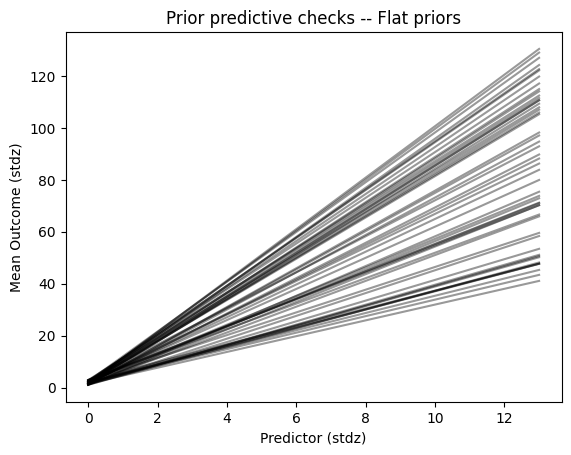

In [53]:
from matplotlib import pyplot as plt


_, ax = plt.subplots()

x_lin = np.linspace(0, 13, 50)

for a, b in zip(prior_checks["intercept"], prior_checks["slope"]):
    y_lin = a + b * x_lin
    ax.plot(x_lin, y_lin, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, intercept]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'slope'}>,
        <AxesSubplot: title={'center': 'slope'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

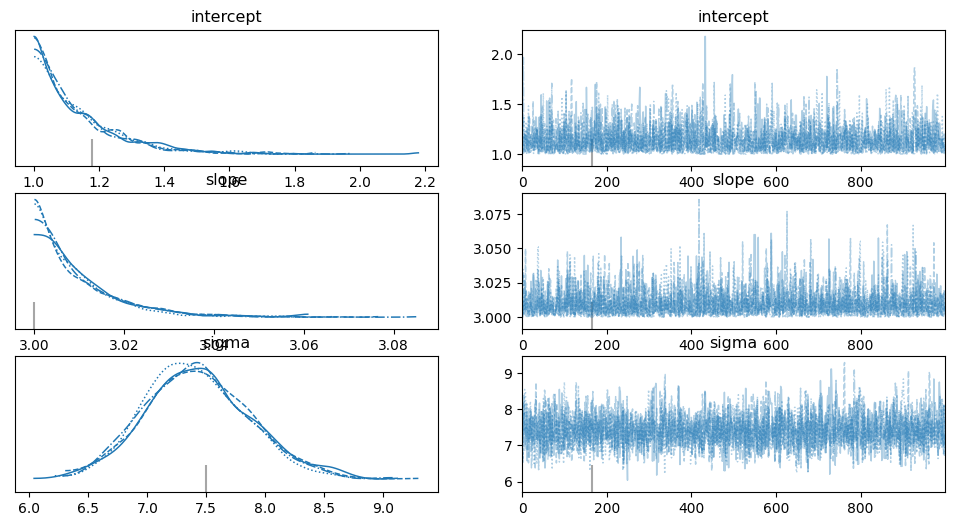

In [54]:
with linear_model:
    trace_1 = pm.sample(1000, tune=2000, random_seed=42, return_inferencedata=True)
az.plot_trace(trace_1)

In [55]:
with linear_model:
    ppc = pm.sample_posterior_predictive(
        trace_1, var_names=["intercept", "slope", "y"], random_seed=42
    )

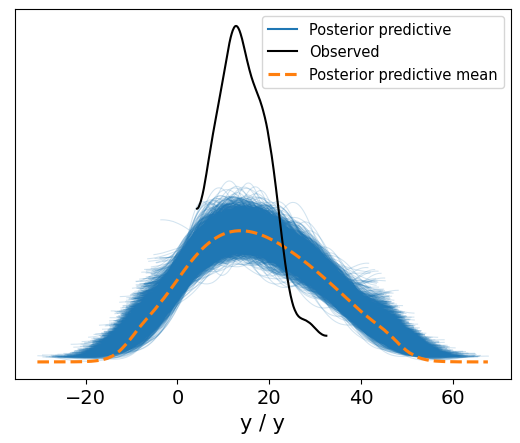

In [56]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=linear_model));


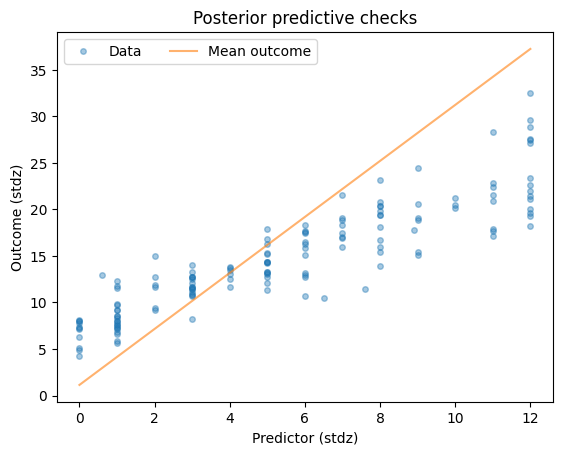

In [60]:
mu_pp = (ppc["intercept"] + ppc["slope"] * x[:, None]).T

_, ax = plt.subplots()

ax.plot(x, y, "o", ms=4, alpha=0.4, label="Data")
ax.plot(x, mu_pp.mean(0), label="Mean outcome", alpha=0.6)
# az.plot_hpd(
#     y,
#     mu_pp,
#     ax=ax,
#     fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
# )
# az.plot_hpd(
#     x,
#     ppc["obs"],
#     ax=ax,
#     fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Outcome 94% HPD"},
# )

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10);

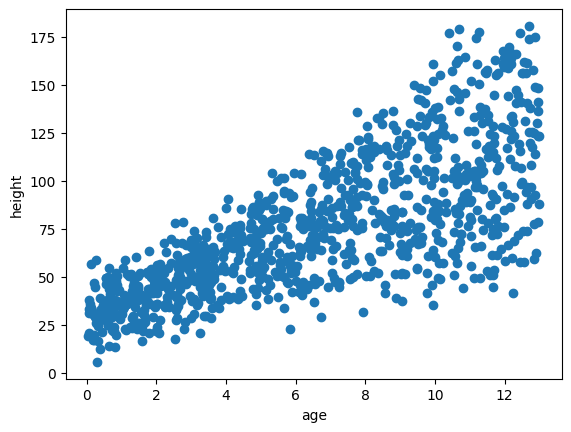

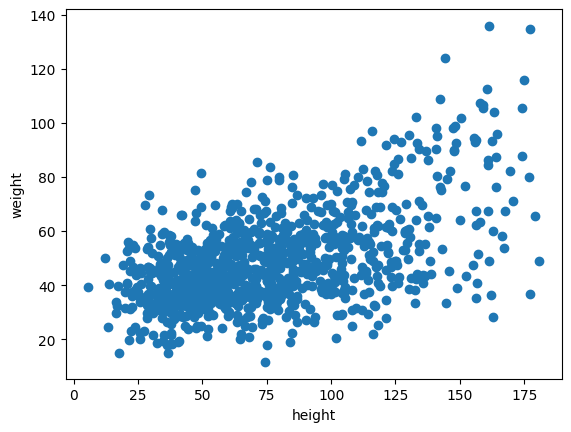

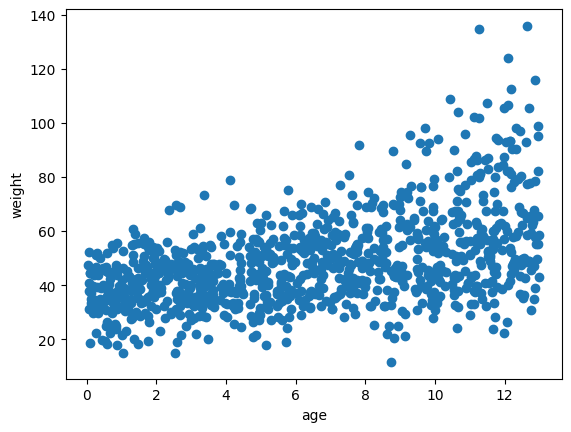

In [19]:
# age -> weight
# age -> height
# height -> weight

# age ~ U(0, 13)
# beta ~ U(0, 20)
# b0 ~ N(0, 10)
# b1 ~ N(0, 10)
# intercept_0 ~ N(120, 100)
# intercept_1 ~ N(60, 10)
# height ~ intercept_0 + age * beta
# weight ~ intercept_1 + height * b0 + age * b1

from matplotlib import pyplot as plt
import numpy as np


n_data = 1000
age = np.random.uniform(0, 13, n_data)
beta = np.random.uniform(2, 12, n_data)
b0 = np.random.uniform(1, 5, n_data)
b1 = np.random.uniform(0, 0.01, n_data)
intercept_0 = np.random.normal(30, 10, n_data)
intercept_1 = np.random.normal(40, 10, n_data)
height = intercept_0 + age * beta
weight = intercept_1 + age * b1 * height * b0

# Plot age vs height, height vs weight, age vs weight

plt.scatter(age, height)
plt.ylabel("height")
plt.xlabel("age")
plt.show()

plt.scatter(height, weight)
plt.ylabel("weight")
plt.xlabel("height")
plt.show()


plt.scatter(age, weight)
plt.ylabel("weight")
plt.xlabel("age")
plt.show()


2. Use a linear regression to estimate the total causal effect of each year of
growth on weight.


3. Now suppose the causal association between age and weight might be different for boys and girls. Use a single linear regression, with a categorical
variable for sex, to estimate the total causal effect of age on weight separately
for boys and girls. How do girls and boys differ? Provide one or more posterior contrasts as a summary.


4 - OPTIONAL CHALLENGE. The data in data(Oxboys) (rethinking
package) are growth records for 26 boys measured over 9 periods. I want
you to model their growth. Specifically, model the increments in growth
from one period (Occasion in the data table) to the next. Each increment is
simply the difference between height in one occasion and height in the previous occasion. Since none of these boys shrunk during the study, all of the
growth increments are greater than zero. Estimate the posterior distribution
of these increments. Constrain the distribution so it is always positive—it
should not be possible for the model to think that boys can shrink from year
to year. Finally compute the posterior distribution of the total growth over
all 9 occasions.